In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

In [44]:
# Crea i dati per predire il prezzo a distanza di una settimana

stock = "AAPL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 


df["Target"] = df["Close"].shift(-7)
df.dropna(inplace=True)
Y = df["Target"]
X = df.drop(columns=["Close", "Target"])
tscv = TimeSeriesSplit(n_splits=2)

data_set = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    data_set.append({
        "X_train": X_train.copy(),
        "X_test": X_test.copy(),
        "Y_train": Y_train.copy(),
        "Y_test": Y_test.copy()
    })

print(X_train.head(1))

               Volume    Return  Return_mean_5  Return_std_5  Return_mean_10  \
Date                                                                           
2015-03-16  143497200  0.011004        0.01732       0.01732        0.012886   

                  SMA      EMA50      MACD  MACD_Signal  Close_STD20  ...  \
Date                                                                  ...   
2015-03-16  28.451758  27.004461  0.215956     0.470947     0.616881  ...   

            Close_lag1  Close_lag3  Close_lag7  Return_lag1  Return_lag3  \
Date                                                                       
2015-03-16   27.533674   27.232924   28.161921     -0.00691    -0.018231   

            Return_lag7         %K         %D  Dist_low_band  Dist_up_band  
Date                                                                        
2015-03-16     -0.01657  33.299771  24.410996       0.022224     -0.066419  

[1 rows x 22 columns]


Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 6.0858 | MAE: 4.4438 | R2: 0.9791
Top coefficients:
Boll_Up           5.166665
EMA50             1.643358
Dist_up_band      0.960495
Close_lag1        0.730515
Close_STD20       0.213692
Return_mean_5     0.105767
%K                0.083765
Return_mean_10    0.080904
Volume            0.073369
Return            0.060417


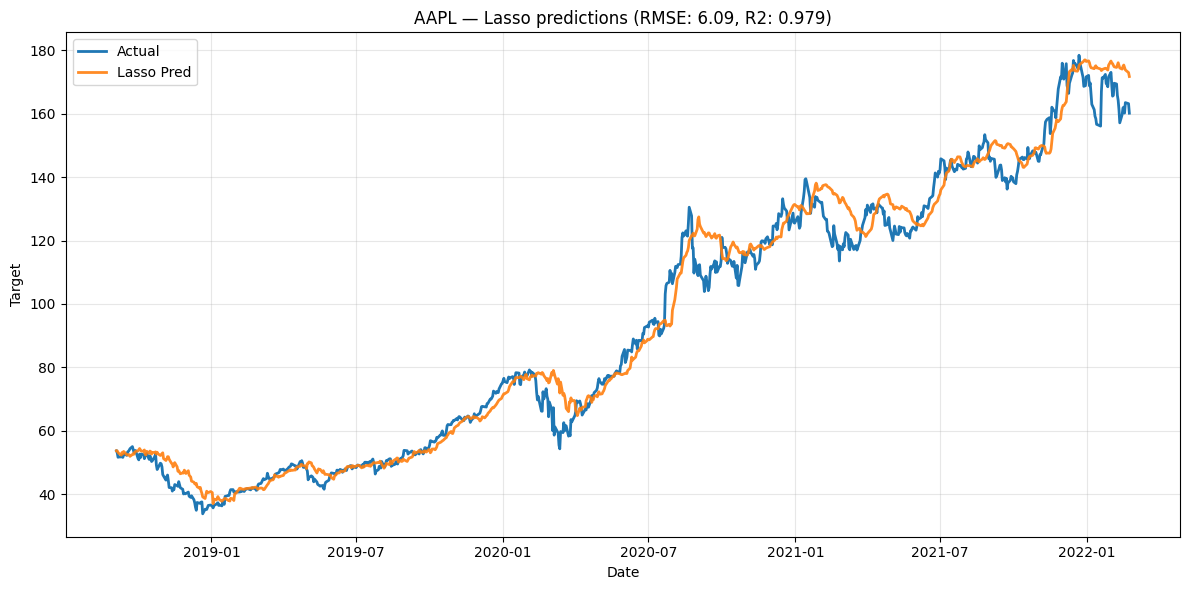

Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 9.0647 | MAE: 6.9165 | R2: 0.9201
Top coefficients:
SMA               30.102135
EMA50             12.150292
MACD               6.540834
MACD_Signal        4.689945
Dist_low_band      0.774940
%D                 0.573494
Dist_up_band       0.483085
Return_mean_10     0.393864
%K                 0.301568
Return             0.282238


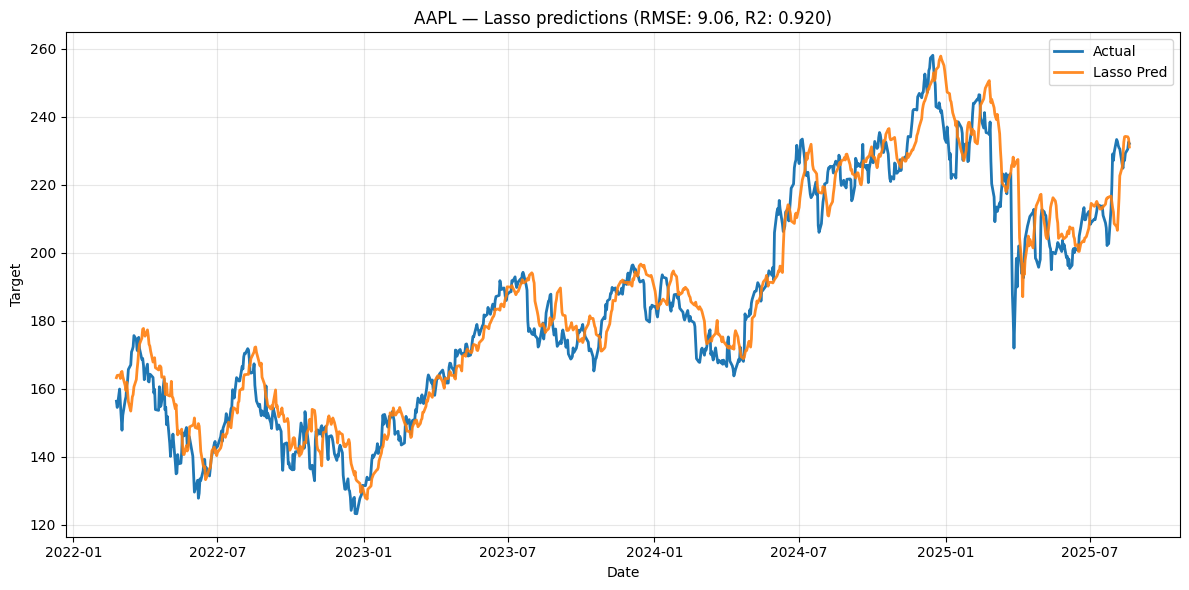

In [45]:
for data in data_set:
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.01, 0.1, 0.5, 0.5, 1.0],
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

    # display top coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)
    print("Top coefficients:")
    print(coefs.abs().sort_values(ascending=False).head(10).to_string())

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — Lasso predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Stock: AAPL
Best params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}
RMSE: 59.0166 | MAE: 43.8401 | R2: -0.9639
Top features:
 SMA            0.168878
EMA50          0.155030
Boll_Down      0.141439
Close_lag1     0.140223
Close_lag3     0.136739
Close_lag7     0.104158
Boll_Up        0.093823
MACD           0.019953
MACD_Signal    0.010632
Close_STD20    0.008228


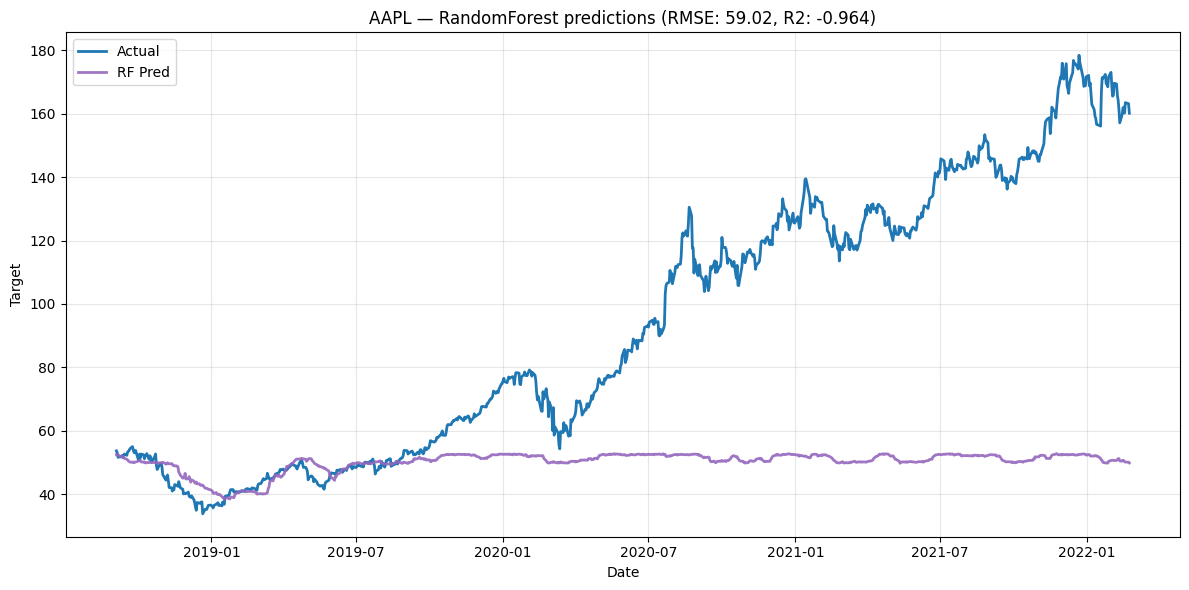

Stock: AAPL
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 36.3748 | MAE: 27.5809 | R2: -0.2866
Top features:
 Close_lag3     0.174417
Close_lag1     0.154252
SMA            0.152982
Boll_Up        0.138642
EMA50          0.128394
Close_lag7     0.100031
Boll_Down      0.076968
Close_STD20    0.030334
MACD           0.022371
MACD_Signal    0.011071


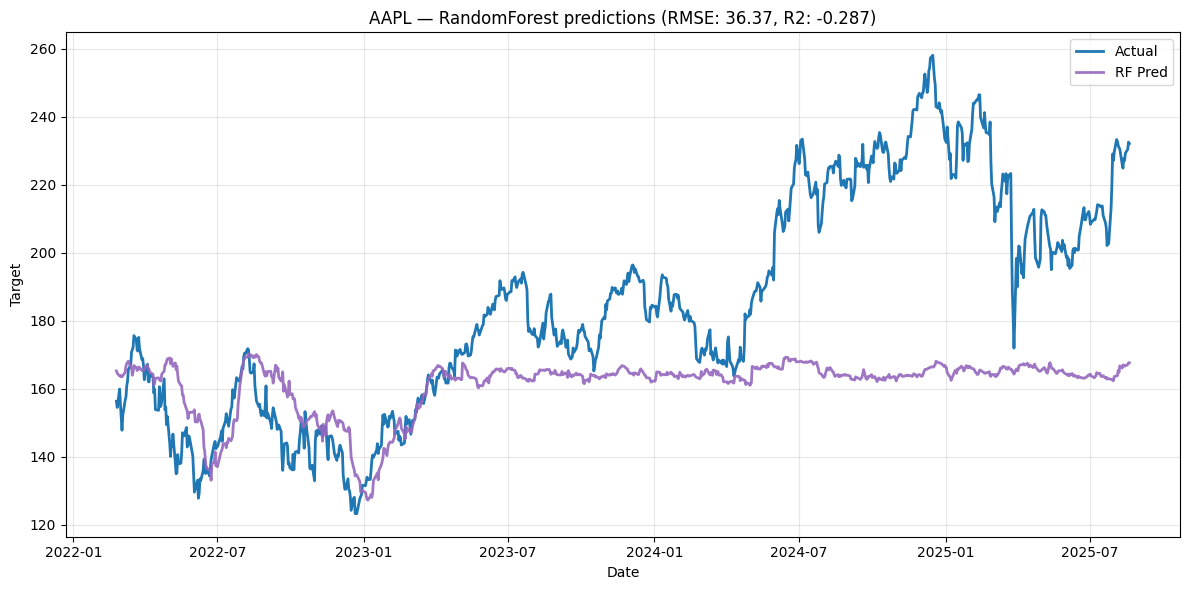

In [46]:
for data in data_set:
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [200, 500, 1000],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    }
    gs = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

    # feature importances
    try:
        fi = pd.Series(best.feature_importances_, index=data["X_train"].columns)
        print("Top features:\n", fi.sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='RF Pred', color='#9467bd', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — RandomForest predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
